Model interprets reviews from Yelp
Each of the reviews have stars
FOr 5 star reviews, extract features- then construct a fake five star review


We have two GPTS
1. Extract features from text
2. Generate text from features

```
`# This is formatted as code`
```



### Solve environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install transformers
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.9 MB/s eta 0:00:00


In [3]:
import os
import json
import csv
import re
import string
import time

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
from sklearn.manifold import TSNE
import torch
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import GPT2Config, GPT2Tokenizer, GPT2Model, TrainingArguments, Trainer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup

import logging
logging.getLogger().setLevel(logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Dataset

**Create PyTorch Dataset module**


For fine-tuning the GPT2 model, we use the officially review data published by yelp. After each review, we add `<|endoftext|>`, which will be recognized by the GPT2 model as and end of text marker. The marker allow us to concatenate many reviews in an input sequence.


In [ ]:
SPECIAL_TOKENS = {"bos_token": "<|BOS|>",
                  ## special token (beginning.of.sequence)
                  ## read reviews and construct files

                  "eos_token": "<|EOS|>",
                  "unk_token": "<|UNK|>",
                  "pad_token": "<|PAD|>",
                  "sep_token": "<|SEP|>"}

In [ ]:
# can create class named review dataset
# everytime you call, you can get access to the review in the original datafile

class ReviewDataset(Dataset):
    def __init__(self, tokenizer, dataset_path = '/content/drive/MyDrive/CPSC452_final_project/data/'):
        super().__init__()
        self.dataset_path = dataset_path

        review_path = os.path.join(self.dataset_path, 'yelp_academic_dataset_review.csv')
        reviews = self.load_data(review_path)

        self.input_ids = []
        self.attention_masks = []
        self.keywords = []

        dataset_len = len(reviews.loc[:, 'text'])


# use tokens to extract the begining/end/middle parts of reviews for each entry
# cvs has original review
# process each review separately
# input_ids has the list of all the reviews
# tokens are to help separate the reviews (since reviews are originally merged in the dataset)

        for i in range(dataset_len):
            review = reviews.loc[i, 'text']
            star = reviews.loc[i, 'stars']
            encodings_dict = tokenizer(SPECIAL_TOKENS['bos_token'] + str(star) + ' stars: ' +
                                       SPECIAL_TOKENS['sep_token'] + review + SPECIAL_TOKENS['eos_token'],
                                       truncation=True, max_length=32, padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attention_masks.append(torch.tensor(encodings_dict['attention_mask']))
            self.keywords.append(star)


# loading data
    def load_data(self, path):
        reviews = pd.read_csv(path)
        reviews = reviews[reviews['useful']>=1]
        reviews = reviews[['stars', 'text']].head(10000)
        reviews = reviews.dropna()
        reviews = reviews[reviews.stars.apply(lambda x: x !="")]
        reviews = reviews[reviews.text.apply(lambda x: x !="")]
        reviews['text'] = reviews['text'].map(lambda x: self.clean_text(x))
        reviews = reviews.reset_index()
        return reviews

# make review readable
    def clean_text(self, text):
        ## Remove puncuation
        text = text.translate(string.punctuation)
        ## Convert words to lower case and split them
        text = text.split()
        ## Remove stop words
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
        # Clean the text
        text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
        return text

# return length of dataset
    def __len__(self):
        return len(self.input_ids)

# get one items from dataset
    def __getitem__(self, item):
        return self.input_ids[item], self.attention_masks[item], self.keywords[item]

NameError: ignored

In [ ]:
# map words to different numeric vectors so machine can read

tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
tokenizer.add_special_tokens(SPECIAL_TOKENS)

4

In [ ]:
# create review dataset and split into training set and validation set
# use validation set if the model performs well

review_dataset = ReviewDataset(tokenizer=tokenizer)
train_size = int(0.9 * len(review_dataset))
train_dataset, val_dataset = random_split(review_dataset, [train_size, len(review_dataset) - train_size])

ParserError: ignored

In [ ]:
torch.save(train_dataset, '/content/drive/MyDrive/CPSC452_final_project/data/train.pt')
torch.save(val_dataset, '/content/drive/MyDrive/CPSC452_final_project/data/val.pt')

### Hyperparameters

In [ ]:
## don't worry :")

MODEL_FOLDER = "/content/drive/MyDrive/CPSC452_final_project/trained_models"
LOGGING_FOLDER = "/content/drive/MyDrive/CPSC452_final_project/log"
if not os.path.exists(LOGGING_FOLDER):
    os.mkdir(LOGGING_FOLDER)
if not os.path.exists(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)

BATCH_SIZE = 16
EPOCHS = 5
EPSILON = 1e-8
LEARNING_RATE = 3e-5
WARMUP_STEPS = 100

### Model Training

In [ ]:
train_dataset = torch.load('/content/drive/MyDrive/CPSC452_final_project/data/train.pt')
val_dataset = torch.load('/content/drive/MyDrive/CPSC452_final_project/data/val.pt')
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset),
                              batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset),
                            batch_size = BATCH_SIZE)

configuration = GPT2Config.from_pretrained('gpt2-medium',
                                           bos_token_id=tokenizer.bos_token_id,
                                           eos_token_id=tokenizer.eos_token_id,
                                           sep_token_id=tokenizer.sep_token_id,
                                           pad_token_id=tokenizer.pad_token_id,
                                           output_hidden_states=True)
model = GPT2LMHeadModel.from_pretrained('gpt2-medium', config=configuration).cuda()
model.resize_token_embeddings(len(tokenizer))
print(model)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
total_step = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = WARMUP_STEPS,
                                            num_training_steps = len(train_dataloader) * EPOCHS)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50261, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50261, bias=False)
)


In [ ]:
model = model.to(device)
training_stats = []
for epoch in range(EPOCHS):
    # ======================================================
    #                        Training
    # ======================================================
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, EPOCHS))
    print('Training...')
    train_loss = 0
    model.train()

    for index, data in enumerate(train_dataloader):
        input_ids = data[0].to(device)
        attention_masks = data[1].to(device)
        labels = data[0].to(device)
        keywords = data[2].to(device)

        model.zero_grad()

        outputs = model(input_ids, labels=labels,
                        attention_mask=attention_masks,token_type_ids=None)
        loss = outputs[0]
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    train_loss /= len(train_dataloader)
    print("  Training loss: {0:.4f}".format(train_loss))

    # ======================================================
    #                       Validating
    # ======================================================
    print('Validating...')
    eval_loss = 0
    model.eval()

    for data in val_dataloader:
        input_ids = data[0].to(device)
        attention_masks = data[1].to(device)
        labels = data[0].to(device)
        keywords = data[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks,
                            labels=labels, output_hidden_states=True)
            loss = outputs[0]
            hidden_states = outputs.hidden_states[1:]

        eval_loss += loss.item()

    eval_loss /= len(val_dataloader)
    print("  Validation loss: {0:.4f}".format(eval_loss))

    training_stats.append(
        {
            'Epoch': epoch + 1,
            'Training loss': train_loss,
            'Validation loss': eval_loss
        }
    )

print("Training complete!")

======== Epoch 1 / 5 ========
Training...


KeyboardInterrupt: ignored

In [ ]:
self.keywords

View the summary of the training process:

In [ ]:
# printing out loss in table format
# epoch - a cycle after we go through every datapoint in every data set

df = pd.DataFrame(data=training_stats)
df = df.set_index('Epoch')
df

,Training loss,Validation loss
Epoch,,
1,7.213731,4.217490
2,4.182363,4.083767
3,4.031674,4.036867
4,3.946221,4.002507
5,3.890224,3.998819


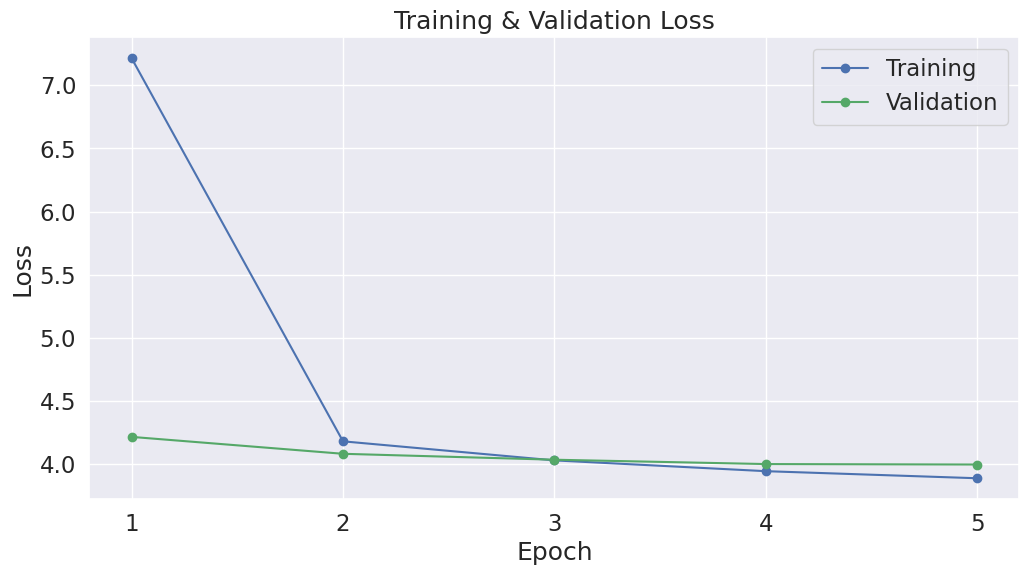

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df['Training loss'], 'b-o', label="Training")
plt.plot(df['Validation loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])
plt.show()


## shows that the model is learning something because the loss is decreasing
## training loss - decreased very sharply because model already saw the training data
## validation loss is less sharp because machine never saw validation data
### (unsure why validation loss is lower - open to further exploration)

### Generating reviews

In [ ]:
prompt = SPECIAL_TOKENS['bos_token'] +  str(5) + ' stars: ' + SPECIAL_TOKENS['sep_token']

# Top-p (nucleus) text generation (20 samples)
generated = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
sample_outputs = model.generate(generated, do_sample=True, top_k=50,
                                max_length=50, top_p=0.95, temperature=1.9, num_return_sequences=20)
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

0: 5 stars:I going  5 years - year's - visit new business place. So, I know know many people visiting Philly. I thought come give new business I coming. ++So went ahead grab drinks before 3rd birthday. First
1: 5 stars:My wife decided try I made reservations lunch Saturday night 10PM Sat lunch, looking lunch spot within 3 blocks I walked past. We noticed sign outside read Restaurant! I got dinner reservations 7PM  45 I noticed 3 people check
2: 5 stars:Best Japanese buffet ever seen in NY. It amazing get yakiniku. My friend ordered get sushi go sushi platter really loved it. As always go koi place 
3: 5 stars:Well, let's call attention I never write glowing 4:40 PM review time every month.....but...Well!+Great place.+Great people. ++I made try couple menu favorites - Seafood Rolls, Pineapp
4: 5 stars:We go twice week sometimes. From I think June 19th... well never. Just going back two week, great experience experience, nice little venue....++Just really liked food, service always well.

### Visualize embeddings

In [ ]:
dim_reducer = TSNE(n_components=2)
FIGURE_FOLDER = "/content/drive/MyDrive/CPSC452_final_project/figure"
def visualize_layerwise_embeddings(hidden_states,masks,labels,layers_to_visualize):
    num_layers = len(layers_to_visualize)

    fig = plt.figure(figsize=(24,(num_layers/4)*6)) #each subplot of size 6x6, each row will hold 4 plots
    ax = [fig.add_subplot(num_layers/4,4,i+1) for i in range(num_layers)]

    labels = labels.numpy().reshape(-1)
    for i,layer_i in enumerate(layers_to_visualize):
        layer_embeds = hidden_states[layer_i]

        layer_averaged_hidden_states = torch.div(layer_embeds.sum(dim=1),masks.sum(dim=1,keepdim=True))
        layer_dim_reduced_embeds = dim_reducer.fit_transform(layer_averaged_hidden_states.numpy())

        df = pd.DataFrame.from_dict({'x':layer_dim_reduced_embeds[:,0],'y':layer_dim_reduced_embeds[:,1],'label':labels})

        sns.scatterplot(data=df,x='x',y='y',hue='label',ax=ax[i])

    plt.savefig(f'/tmp/plots/{title}',format='png',pad_inches=0)


### DetectGPT